# DETECCIÓN DE EMOCIONES POR MEDIO DE EXPRESIONES EN EL HABLA (SER) 



En primer lugar se importan las librerías que se van a emplear el en código

In [3]:
import os
import pandas as pd
import numpy as np

import librosa
import matplotlib.pyplot as plt


from pydub import AudioSegment, effects

from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

from keras.models import Sequential
from keras import layers, optimizers, callbacks

from sklearn.metrics import confusion_matrix

import seaborn as sns

 Se imprime el directorio de trabajo actual.

In [4]:
import os
!python --version
os.getcwd()

Python 3.10.9


'/Users/macbook/Documents/ESPECIALIZACIÓN/2do SEMESTRE/INTELIGENCIA ARTIFICIAL/Proyecto'

Ahora se leen los directorios a los datos. 

In [16]:
CREMA = './Base SER/AudioWAV' 
TESS = "./Base SER/TESS Toronto emotional speech set data/TESS Toronto emotional speech set data"
SAVEE = "./Base SER/ALL"

se recorren los archivos en el directorio **CREMA**, se extrae información relevante de los nombres de los archivos y se crea un DataFrame que contiene la ruta del archivo, el género y la emoción asociados a cada archivo de audio.

In [17]:
crema_dir_list = os.listdir(CREMA)
path_list = []
gender_list = []
emotion_list = []

emotion_dic = {
    'HAP' : 'happy',
    'NEU' : 'neutral',
    'SAD' : 'sad',
    'ANG' : 'angry',
    'FEA' : 'fear',
    'DIS' : 'disgust',
}

female_id_list = [
    '1002', '1003', '1004', '1006', '1007', '1008', '1009', '1010', '1012', '1013', '1018', 
    '1020', '1021', '1024', '1025', '1028', '1029', '1030', '1037', '1043', '1046', '1047', 
    '1049', '1052', '1053', '1054', '1055', '1056', '1058', '1060', '1061', '1063', '1072', 
    '1073', '1074', '1075', '1076', '1078', '1079', '1082', '1084', '1089', '1091',
]

for audio_file in crema_dir_list:
    part = audio_file.split('_')
    key = part[2]
    if key in emotion_dic and part[3] == 'HI.wav':
        path_list.append(f"{CREMA}/{audio_file}")
        gender_list.append('female' if part[0] in female_id_list else 'male')
        emotion_list.append(emotion_dic[key])

crema_df = pd.concat([
    pd.DataFrame(path_list, columns=['path']),
    pd.DataFrame(gender_list, columns=['sex']),
    pd.DataFrame(emotion_list, columns=['emotion'])
], axis=1)

crema_df.head()




,path,sex,emotion
0,./Base SER/AudioWAV/1028_IEO_SAD_HI.wav,female,sad
1,./Base SER/AudioWAV/1048_IEO_ANG_HI.wav,male,angry
2,./Base SER/AudioWAV/1027_IEO_DIS_HI.wav,male,disgust
3,./Base SER/AudioWAV/1032_IEO_DIS_HI.wav,male,disgust
4,./Base SER/AudioWAV/1080_IEO_HAP_HI.wav,male,happy


recorre los directorios y archivos en el directorio **TESS**, extrae información relevante de los nombres de los archivos y crea un DataFrame que contiene la ruta del archivo, el género y la emoción asociados a cada archivo de audio en el conjunto de datos TESS.

In [18]:
tess_dir_list = os.listdir(TESS)
path_list = []
gender_list = []
emotion_list = []

emotion_dic = {
    'happy': 'happy',
    'neutral': 'neutral',
    'sad': 'sad',
    'Sad': 'sad',
    'angry': 'angry',
    'fear': 'fear',
    'disgust': 'disgust',
}

for directory in tess_dir_list:
    audio_files = os.listdir(os.path.join(TESS, directory))
    for audio_file in audio_files:
        part = audio_file.split('.')[0]
        key = part.split('_')[2]
        if key in emotion_dic:
            path_list.append(f"{TESS}/{directory}/{audio_file}")
            gender_list.append('female')  # Solo conjunto de datos femenino
            emotion_list.append(emotion_dic[key])

tess_df = pd.concat([
    pd.DataFrame(path_list, columns=['path']),
    pd.DataFrame(gender_list, columns=['sex']),
    pd.DataFrame(emotion_list, columns=['emotion'])
], axis=1)

tess_df.head()

,path,sex,emotion
0,./Base SER/TESS Toronto emotional speech set d...,female,disgust
1,./Base SER/TESS Toronto emotional speech set d...,female,disgust
2,./Base SER/TESS Toronto emotional speech set d...,female,disgust
3,./Base SER/TESS Toronto emotional speech set d...,female,disgust
4,./Base SER/TESS Toronto emotional speech set d...,female,disgust


Se repite el proceso para las bases anteriores pero esta vez con la base **SAVEE**.

In [26]:
savee_dir_list = os.listdir(SAVEE)
path_list = []
gender_list = []
emotion_list = []

emotion_dic = {
    'h'  : 'happy',
    'n'  : 'neutral',
    'sa' : 'sad',
    'a'  : 'angry',
    'f'  : 'fear',
    'd'  : 'disgust'
}

for audio_file in savee_dir_list:
    part = audio_file.split('_')[1]
    key = part[:-6]
    if key in emotion_dic:
        path_list.append(f"{SAVEE}/{audio_file}")
        gender_list.append('male') # male only dataset
        emotion_list.append(emotion_dic[key])
        
savee_df = pd.concat([
    pd.DataFrame(path_list, columns=['path']),
    pd.DataFrame(gender_list, columns=['sex']),
    pd.DataFrame(emotion_list, columns=['emotion'])
], axis=1)

savee_df.head()

,path,sex,emotion
0,./Base SER/ALL/JK_sa01.wav,male,sad
1,./Base SER/ALL/JK_sa15.wav,male,sad
2,./Base SER/ALL/DC_n13.wav,male,neutral
3,./Base SER/ALL/DC_n07.wav,male,neutral
4,./Base SER/ALL/JK_n20.wav,male,neutral


Se crea un *dataframe* con los datos de las tres bases anteriores.

In [27]:
df = pd.concat([
    crema_df, 
    tess_df, 
    savee_df
], axis=0)
df.head()

,path,sex,emotion
0,./Base SER/AudioWAV/1028_IEO_SAD_HI.wav,female,sad
1,./Base SER/AudioWAV/1048_IEO_ANG_HI.wav,male,angry
2,./Base SER/AudioWAV/1027_IEO_DIS_HI.wav,male,disgust
3,./Base SER/AudioWAV/1032_IEO_DIS_HI.wav,male,disgust
4,./Base SER/AudioWAV/1080_IEO_HAP_HI.wav,male,happy


Se grafícan los datos de **df** teniendo en cuenta emoción y genero.

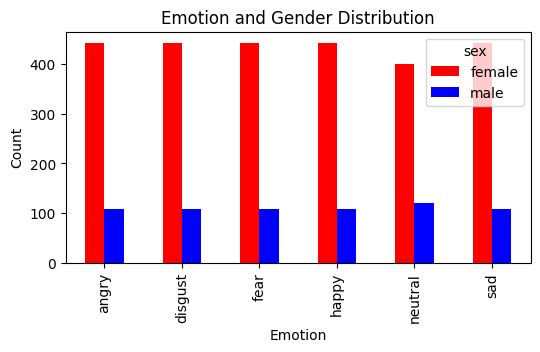

In [28]:
def plot_distribution(df): 
    countTable = df.groupby(['emotion', 'sex']).count()
    pivotTable = countTable.pivot_table(index='emotion', columns='sex', values='path')

    pivotTable.plot(kind='bar', figsize=(6, 3), color=['red', 'blue'])
    plt.title('Emotion and Gender Distribution')
    plt.xlabel('Emotion')
    plt.ylabel('Count')
    plt.show()
    
plot_distribution(df)

Se plotean los primeros valores del nuevo dataframe **df**

In [29]:
df.drop('sex', axis=1, inplace=True)
df.head()

,path,emotion
0,./Base SER/AudioWAV/1028_IEO_SAD_HI.wav,sad
1,./Base SER/AudioWAV/1048_IEO_ANG_HI.wav,angry
2,./Base SER/AudioWAV/1027_IEO_DIS_HI.wav,disgust
3,./Base SER/AudioWAV/1032_IEO_DIS_HI.wav,disgust
4,./Base SER/AudioWAV/1080_IEO_HAP_HI.wav,happy


Se define el proceso **preprocess_audio** donde se carga un archivo de audio, elimina los segmentos de silencio MEDIANTE ***trim()***, ajusta la longitud a 180,000 muestras y devuelve el audio preprocesado junto con la tasa de muestreo.

In [30]:
def preprocess_audio(path):
    _, sr = librosa.load(path)
    raw_audio = AudioSegment.from_file(path)
    
    samples = np.array(raw_audio.get_array_of_samples(), dtype='float32')
    trimmed, _ = librosa.effects.trim(samples, top_db=25)
    padded = np.pad(trimmed, (0, 180000-len(trimmed)), 'constant')
    return padded, sr

Se usa la función ***encode()***, esta busca el valor correspondiente a la etiqueta dada en el diccionario utilizando el método ***get()*** y devuelve ese valor, es decir, si llamamos a ***encode('happy')***, la función retornará 1.

In [31]:
emotion_dic = {
    'neutral' : 0,
    'happy'   : 1,
    'sad'     : 2, 
    'angry'   : 3, 
    'fear'    : 4, 
    'disgust' : 5
}

def encode(label):
    return emotion_dic.get(label)

Se procesan los archivos de audio especificados en un **DataFrame** utilizando ***librosa*** para extraer características como la tasa de cruce por cero, el valor cuadrático medio y los coeficientes cepstrales de frecuencia Mel. Los resultados se almacenan en listas separadas para cada característica y para la emoción asociada a cada archivo.

En caso de que la ruta de tratamiento no funciones se generara una salida con la ruta del archivo que no pudo ser procesado.

Para la creación del conjunto de datos no pudieron procesarse 112 archivos de **TESS** df

In [32]:
zcr_list = []
rms_list = []
mfccs_list = []
emotion_list = []

FRAME_LENGTH = 2048
HOP_LENGTH = 512

for row in df.itertuples(index=False):
    try: 
        y, sr = preprocess_audio(row.path)

        zcr = librosa.feature.zero_crossing_rate(y, frame_length=FRAME_LENGTH, hop_length=HOP_LENGTH)
        rms = librosa.feature.rms(y=y, frame_length=FRAME_LENGTH, hop_length=HOP_LENGTH)
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13, hop_length=HOP_LENGTH)

        zcr_list.append(zcr)
        rms_list.append(rms)
        mfccs_list.append(mfccs)

        emotion_list.append(encode(row.emotion))
    except:
        print(f"Failed for path:{row.path}")

/Users/macbook/anaconda3/lib/python3.10/site-packages/pydub/utils.py:198: RuntimeWarning: Couldn't find ffprobe or avprobe - defaulting to ffprobe, but may not work
  warn("Couldn't find ffprobe or avprobe - defaulting to ffprobe, but may not work", RuntimeWarning)


Failed for path:./Base SER/TESS Toronto emotional speech set data/TESS Toronto emotional speech set data/YAF_fear/YAF_neat_fear.wav


/Users/macbook/anaconda3/lib/python3.10/site-packages/pydub/utils.py:198: RuntimeWarning: Couldn't find ffprobe or avprobe - defaulting to ffprobe, but may not work
  warn("Couldn't find ffprobe or avprobe - defaulting to ffprobe, but may not work", RuntimeWarning)


Failed for path:./Base SER/TESS Toronto emotional speech set data/TESS Toronto emotional speech set data/YAF_angry/YAF_germ_angry.wav
Failed for path:./Base SER/ALL/JK_sa01.wav
Failed for path:./Base SER/ALL/JK_sa15.wav
Failed for path:./Base SER/ALL/JE_sa08.wav
Failed for path:./Base SER/ALL/JK_f15.wav
Failed for path:./Base SER/ALL/KL_sa13.wav
Failed for path:./Base SER/ALL/DC_h15.wav
Failed for path:./Base SER/ALL/DC_h14.wav
Failed for path:./Base SER/ALL/KL_sa12.wav
Failed for path:./Base SER/ALL/DC_n06.wav
Failed for path:./Base SER/ALL/JK_sa14.wav
Failed for path:./Base SER/ALL/JK_sa02.wav
Failed for path:./Base SER/ALL/DC_n10.wav
Failed for path:./Base SER/ALL/KL_sa04.wav
Failed for path:./Base SER/ALL/KL_sa10.wav
Failed for path:./Base SER/ALL/JK_d14.wav
Failed for path:./Base SER/ALL/JK_d15.wav
Failed for path:./Base SER/ALL/KL_sa11.wav
Failed for path:./Base SER/ALL/JK_d01.wav
Failed for path:./Base SER/ALL/KL_sa05.wav
Failed for path:./Base SER/ALL/DC_n11.wav
Failed for path

Aquí se combinan las características extraídas de las muestras de audio (ZCR, RMS y MFCC) en una matriz X y las etiquetas de emoción en un arreglo y, ambos en un formato adecuado para ser utilizado en un modelo de aprendizaje automático.

In [33]:
X = np.concatenate((
    np.swapaxes(zcr_list, 1, 2), 
    np.swapaxes(rms_list, 1, 2), 
    np.swapaxes(mfccs_list, 1, 2)), 
    axis=2
)
X = X.astype('float32')

y = np.asarray(emotion_list)
y = np.expand_dims(y, axis=1).astype('int8')

Se divide el conjunto de datos en conjuntos de entrenamiento, validación y prueba, y realiza la codificación categórica de las etiquetas de clase para los conjuntos de entrenamiento y validación.

Se agregan dos capas **LSTM**, cada una con 64 unidades, y se especifica que la primera capa debe devolver secuencias completas. La segunda capa **LSTM** devuelve solo la última salida. Luego se agrega una capa densa con 6 unidades y función de activación ***softmax*** para generar probabilidades de pertenecer a cada una de las 6 clases de emociones. Se imprime un resumen del modelo que muestra información detallada sobre la estructura y los parámetros entrenables.

In [34]:
X_train, X_to_split, y_train, y_to_split = train_test_split(X, y, test_size=0.15, random_state=1)
X_val, X_test, y_val, y_test = train_test_split(X_to_split, y_to_split, test_size=0.3, random_state=1)

y_train_class = to_categorical(y_train, 6)
y_val_class = to_categorical(y_val, 6)

Se define un modelo de red neuronal recurrente (RNN) utilizando la clase Sequential de Keras. El modelo consta de dos capas **LSTM** (***Long Short-Term Memory***) y una capa densa de salida.



In [35]:
MODEL = Sequential()
MODEL.add(layers.LSTM(64, return_sequences=True, input_shape=(X.shape[1:3])))
MODEL.add(layers.LSTM(64))
MODEL.add(layers.Dense(6, activation='softmax'))

print(MODEL.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 352, 64)           20480     
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 6)                 390       
                                                                 
Total params: 53,894
Trainable params: 53,894
Non-trainable params: 0
_________________________________________________________________
None


SE realiza el entrenamiento de un modelo de aprendizaje profundo utilizando Keras:

- Se utiliza una ***callback*** para ajustar automáticamente la tasa de aprendizaje del modelo. 
- El modelo se compila con una ***función de pérdida de entropía cruzada categórica***, un ***optimizador RMSProp*** y se evalúa la precisión categórica. 
- Se realiza el entrenamiento del modelo utilizando los datos de entrenamiento y validación proporcionados. El entrenamiento se lleva a cabo durante **100 épocas**, utilizando **lotes de tamaño 32**. 

El resultado del entrenamiento se guarda en una variable llamada "model".

In [36]:
rlrop = callbacks.ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=0.2, patience=70)
MODEL.compile(loss='categorical_crossentropy', optimizer='RMSProp', metrics=['categorical_accuracy'])
model = MODEL.fit(X_train, y_train_class, epochs=100, batch_size=32, validation_data=(X_val, y_val_class))

Epoch 1/100
84/84 [==============================] - 40s 421ms/step - loss: 1.6245 - categorical_accuracy: 0.2768 - val_loss: 1.6719 - val_categorical_accuracy: 0.2931
Epoch 2/100
84/84 [==============================] - 34s 410ms/step - loss: 1.5336 - categorical_accuracy: 0.3368 - val_loss: 1.4985 - val_categorical_accuracy: 0.3867
Epoch 3/100
84/84 [==============================] - 34s 408ms/step - loss: 1.4867 - categorical_accuracy: 0.3514 - val_loss: 1.5413 - val_categorical_accuracy: 0.3746
Epoch 4/100
84/84 [==============================] - 35s 411ms/step - loss: 1.4834 - categorical_accuracy: 0.3685 - val_loss: 1.5104 - val_categorical_accuracy: 0.4441
Epoch 5/100
84/84 [==============================] - 34s 399ms/step - loss: 1.4510 - categorical_accuracy: 0.3868 - val_loss: 1.4954 - val_categorical_accuracy: 0.3837
Epoch 6/100
84/84 [==============================] - 34s 401ms/step - loss: 1.4150 - categorical_accuracy: 0.4110 - val_loss: 1.4575 - val_categorical_accuracy:

84/84 [==============================] - 35s 418ms/step - loss: 0.5770 - categorical_accuracy: 0.7747 - val_loss: 0.6656 - val_categorical_accuracy: 0.7190
Epoch 50/100
84/84 [==============================] - 34s 411ms/step - loss: 0.5776 - categorical_accuracy: 0.7758 - val_loss: 0.6501 - val_categorical_accuracy: 0.7341
Epoch 51/100
84/84 [==============================] - 35s 411ms/step - loss: 0.5586 - categorical_accuracy: 0.7833 - val_loss: 0.6708 - val_categorical_accuracy: 0.7130
Epoch 52/100
84/84 [==============================] - 37s 437ms/step - loss: 0.5487 - categorical_accuracy: 0.7837 - val_loss: 0.6338 - val_categorical_accuracy: 0.7644
Epoch 53/100
84/84 [==============================] - 38s 457ms/step - loss: 0.5630 - categorical_accuracy: 0.7784 - val_loss: 0.6773 - val_categorical_accuracy: 0.7160
Epoch 54/100
84/84 [==============================] - 34s 402ms/step - loss: 0.5593 - categorical_accuracy: 0.7807 - val_loss: 0.7138 - val_categorical_accuracy: 0.6949

84/84 [==============================] - 35s 413ms/step - loss: 0.3968 - categorical_accuracy: 0.8452 - val_loss: 0.5226 - val_categorical_accuracy: 0.8006
Epoch 98/100
84/84 [==============================] - 36s 432ms/step - loss: 0.3770 - categorical_accuracy: 0.8508 - val_loss: 0.5397 - val_categorical_accuracy: 0.7976
Epoch 99/100
84/84 [==============================] - 40s 471ms/step - loss: 0.4115 - categorical_accuracy: 0.8392 - val_loss: 0.5941 - val_categorical_accuracy: 0.7946
Epoch 100/100
84/84 [==============================] - 35s 418ms/step - loss: 0.4075 - categorical_accuracy: 0.8385 - val_loss: 0.6176 - val_categorical_accuracy: 0.7644


Se guarda el modelo **SER.h5**

In [37]:
MODEL.save('SER.h5')

Se genera una **gráfica** que muestra la **pérdida del modelo** en los conjuntos de entrenamiento y validación a lo largo de las épocas.

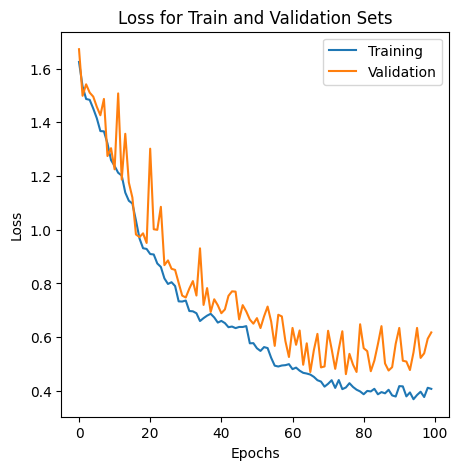

In [38]:
plt.figure(figsize=(5, 5)) 
plt.plot(model.history['loss'])
plt.plot(model.history['val_loss'])
plt.title('Loss for Train and Validation Sets')
plt.ylabel('Loss') 
plt.xlabel('Epochs')
plt.legend(['Training','Validation']) 
plt.show()

Se genera una **gráfica** que muestra la **precisión del modelo** en los conjuntos de entrenamiento y validación a lo largo de las épocas.

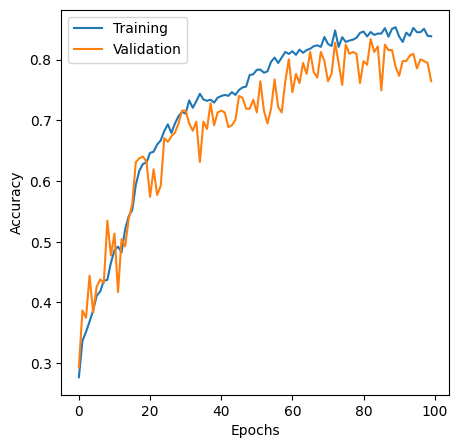

In [39]:
plt.figure(figsize=(5, 5)) 
plt.plot(model.history['categorical_accuracy'])
plt.plot(model.history['val_categorical_accuracy'])
plt.ylabel('Accuracy') 
plt.xlabel('Epochs') 
plt.legend(['Training','Validation']) 
plt.show()

Se calcula la **matriz de confusión** entre las clases verdaderas y las predichas por el modelo en el conjunto de validación. 

Se observa precisión en el modelo.

11/11 [==============================] - 3s 173ms/step


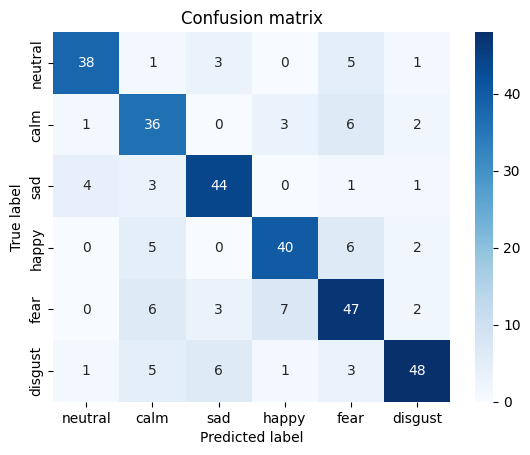

In [40]:
y_pred = np.argmax(MODEL.predict(X_val), axis=1)
labels = ['neutral', 'calm', 'sad', 'happy', 'fear', 'disgust']
cma = confusion_matrix(np.argmax(y_val_class, axis=1), y_pred, labels=range(6))

sns.heatmap(cma, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion matrix')
plt.show()

Se calcula y muestra la **precisión general del modelo**, **la precisión**, el **recall** y la **puntuación F1** para la clase ***'calm'*** basándose en la **matriz de confusión generada**. 

In [41]:
accuracy = np.trace(cma) / np.sum(cma)
precision = cma[1, 1] / np.sum(cma[:, 1])
recall = cma[1, 1] / np.sum(cma[1, :])
f1 = 2 * (precision * recall) / (precision + recall)

# Print metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Accuracy: 0.7643504531722054
Precision: 0.6428571428571429
Recall: 0.75
F1 Score: 0.6923076923076924
